## Primeiramente temos as funções necessárias para o cálculo do nosso Kmeans

In [1]:
import numpy as np
import copy
import math
import random 
def turnIntoMatrix(filepath):
    file = open(filepath, "r")
    lines = file.readlines()
    file.close()
    
    ##Preparing the list of lists 
    matrix = []
    
    for line in lines:
        ##sample will store all the values found 
        ##in a line which represents a sample when the string values were turned into numbers 
        sample = []
        line = line.replace("\n", "")
        split = line.split(",")
        for value in split:
            sample.append(float(value))
        matrix.append(sample)
    return matrix 
def euclideanDistance(point1 , point2): 
    if len(point1) != len(point2):
        raise Exception("List lenght doesn't match")
    else: 
        i = 0
        squareSum= 0
        eucliDistance = 0
        while i < len(point1):
            squareSum = squareSum +pow(point1[i] - point2[i],2)
            i = i+1
        eucliDistance = pow(squareSum, 0.5)
        return eucliDistance

def getRandomDataSet(matrix, percentage):
    numberOfSamples = int(round(percentage*len(matrix)))
    trainingSet = random.sample(matrix, numberOfSamples)
    testSet = [elem for elem in matrix if elem not in trainingSet]
    return trainingSet, testSet

def pca(matrix, Q):
    #calculate the mean and subtract from all lines of the original matrix 
    mean = np.mean(matrix[:, :34], axis = 0)
    matriz_meaned = subtract(matrix, mean)
    #extract covariance matrix from the meaned matrix 
    cov_matrix = np.cov(matriz_meaned[:, :34], rowvar = False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
  
    #sort the eigen_values in descending order 
    eigen_values_args_sorted = np.argsort(eigen_values)[::-1]
    eigen_values_sorted = eigen_values[eigen_values_args_sorted]
    #similarly sort the eigenvectors 
    eigen_vectors_sorted = eigen_vectors[:, eigen_values_args_sorted]
    #reduce matrix
    eigen_vector_sub = eigen_vectors_sorted[:, 0:Q]
    reduced_matrix = np.dot(eigen_vector_sub.transpose(), matriz_meaned[:,:34].transpose()).transpose()
    reduced_matrix = np.append(reduced_matrix, matriz_meaned[:,34:], axis = 1)
    #reduced_matrix = np.append(reduced_matrix, )
    return reduced_matrix, eigen_values_sorted, eigen_vector_sub

def subtract(matrix, subarray):
    j = 0
    mat = np.copy(matrix) 
    while j < len(matrix): 
        line = mat[j]
        i = 0
        while i < 34:
            line[i] = line[i] - subarray[i]
            i = i + 1
        mat[j] = line
        j = j + 1
    return matrix

matrix = turnIntoMatrix("dermatology.data.treated")
training, test = getRandomDataSet(matrix, 0.7)
trainingSet = np.array(training)

## Aqui temos as funções do Kmeans e algumas funções auxiliares para a computação

In [2]:
#escolhe pontos randomicos para inicializar as centroides
def centroides(k, matriz):
    number_of_rows = matriz.shape[0]
    random_indices = np.random.choice(number_of_rows, size=k, replace=False)
    centroide = matriz[random_indices, :]
    return centroide

def distancia_centroide(centroide, sample):
    dist = np.array([])
    for i in range(len(centroide)):
        dist = np.append(dist, euclideanDistance(centroide[i], sample))
    return dist

def Kmeans(k, r, trainingSet):
    centroide = centroides(k,trainingSet[:,:34])
    cluster = lista = [[] for _ in range(len(centroide))]
    for t in range(r):
        clusterAnterior = copy.deepcopy(cluster)
        centroideAnterior = copy.deepcopy(centroide)
        cluster = lista = [[] for _ in range(len(centroide))]
        for i in range(len(trainingSet)):
            distancias = distancia_centroide(centroide, trainingSet[i,:34]).tolist()
            index = distancias.index(min(distancias))
            cluster[index].append(trainingSet[i].tolist())
   
        for i in range(len(cluster)):
            if len(cluster[i])!= 0:
                v = np.array(cluster[i][0][:34])
                for j in range(1, len(cluster[i])):
                    v = v + np.array(cluster[i][j][:34])
                centroide[i] = v/len(v)
            else:
                number_of_rows = len(trainingSet)
                random_indices = np.random.choice(number_of_rows, size=1, replace=False)
                centroide[i] = trainingSet[random_indices, :34]
        if t == r-1:
            return (clusterAnterior, centroideAnterior)
            

## Calculo das matrizes Sw e Sb para a computação do índice Ja

In [3]:
###Para um cluster e uma centroide
def calc_sw(centroide, cluster, num_features):
    Sw = np.zeros((num_features,num_features))
    for i in range(len(cluster)):
        aux = np.zeros((num_features, num_features))
        for j in cluster:
            vetor = j[:num_features] - centroide[:num_features]
            #PARA MULTIPLICAR O VETOR POR SUA TRANSPOSTA uma vez que numpy.transpose() não funciona
            for h in range(len(vetor)):
                for l in range(len(vetor)):
                    aux[h][l] = vetor[h]*vetor[l]
        Sw = Sw + aux 
    return Sw

def calc_sb(centroides,clusters, mean, num_features):
    Sb = np.zeros((num_features, num_features))
    for x in range(len(centroides)):
        aux = np.zeros((num_features, num_features))
        vetor = centroides[x][:num_features] - mean[:num_features] 
        for i in range(len(vetor)):
            for j in range(len(vetor)): 
                aux[i][j] = vetor[i]*vetor[j] 
        Sb = Sb + len(clusters[x])*aux 
    return Sb 

###Para vários cluster e várias centroides
def calc_sw2(centroides, clusters, num_features): 
    Sw = np.zeros((num_features,num_features))
    for i in range(len(clusters)):
        if len(clusters[i]) >= 1:
            Sw = Sw + calc_sw(centroides[i], clusters[i], num_features)
    return Sw 
        

## Alguns testes para SW

In [4]:
Ck = np.array([[1,2,3],
              [4,5,6]])
centroide = np.array([2.5,3.5,4.5])

Clusters = np.array([Ck, Ck])
Centroides = np.array([centroide, centroide])
###EXEMPLO############
calc_sw2(Centroides, Clusters, 3)

array([[9., 9., 9.],
       [9., 9., 9.],
       [9., 9., 9.]])

In [5]:
###Exemplo com o Kmeans##############
cluster, centroide = Kmeans(10, 5, trainingSet)
Sw = calc_sw2(centroide, cluster, 34)
Sw[0]

array([ 3.34323529e+02,  2.13107266e+02,  2.71730104e+02,  4.15735294e+01,
        1.54218858e+02,  9.02984429e+01,  3.71470588e+01,  5.90077855e+01,
        1.51564879e+02,  1.54215398e+02, -2.99480969e+00,  6.20873702e+01,
       -7.13555363e+01,  1.10711938e+02,  7.44628028e+01,  5.34584775e+01,
        2.98854671e+02,  1.28995675e+02,  2.31467993e+02,  1.60910900e+02,
        3.03873702e+02,  2.32685986e+02, -2.06513841e+01,  1.22723183e+02,
        6.08330450e+01,  1.64333910e+02,  6.49576125e+01, -1.51423010e+02,
        7.79368512e+01,  2.52811419e+01,  2.37915225e+01,  2.65686851e+02,
        8.09956747e+01,  3.61490398e+03])

## Alguns testes para SB

In [6]:
#Teste SB simples
average = Ck.sum(axis=0)
print(average)
print(calc_sb(Centroides, Clusters, average, 3))

[5 7 9]
[[25. 35. 45.]
 [35. 49. 63.]
 [45. 63. 81.]]


In [7]:
###Exemplo Sb com o Kmeans##############
average = trainingSet.sum(axis=0)/len(trainingSet)
print(average)
calc_sb(centroide, cluster, average, 34)

[ 2.05179283  1.78087649  1.51394422  1.39442231  0.66533865  0.4501992
  0.17928287  0.39442231  0.56972112  0.55378486  0.11952191  0.39840637
  0.14741036  0.50199203  0.31474104  1.39840637  1.92031873  0.5059761
  1.25896414  0.66533865  0.99203187  0.66932271  0.27888446  0.38645418
  0.42231076  0.46215139  0.45418327  0.95219124  0.46215139  0.10358566
  0.11952191  1.90039841  0.56573705 35.93625498  2.77290837]


array([[2.60502578e+02, 2.44233585e+02, 1.93255180e+02, ...,
        2.64930699e+02, 8.91767153e+01, 3.06357143e+03],
       [2.44233585e+02, 2.32574088e+02, 1.79417110e+02, ...,
        2.49085320e+02, 8.43262797e+01, 2.71487450e+03],
       [1.93255180e+02, 1.79417110e+02, 1.47247443e+02, ...,
        1.96144584e+02, 6.95310764e+01, 2.64286166e+03],
       ...,
       [2.64930699e+02, 2.49085320e+02, 1.96144584e+02, ...,
        2.72930775e+02, 9.38050635e+01, 3.18673893e+03],
       [8.91767153e+01, 8.43262797e+01, 6.95310764e+01, ...,
        9.38050635e+01, 5.59216387e+01, 1.66523492e+03],
       [3.06357143e+03, 2.71487450e+03, 2.64286166e+03, ...,
        3.18673893e+03, 1.66523492e+03, 7.75389158e+04]])

## Testando valor do Ja

In [8]:
##Exemplo de traço 
Sw = calc_sw2(centroide, cluster, 34)
Sb = calc_sb(centroide, cluster, average, 34)
Ja = np.outer(np.linalg.inv(Sw),Sb).trace()
print(Ja)

1.626603203164583e+16


## Finalmente o experimento

In [9]:
#Função para o teste
def teste_avaliacao(Kmax, Rmax, trainingSet):
    Jvetor = np.zeros(Kmax)
    mean = trainingSet.sum(axis=0)/len(trainingSet)
    for k in range(2, Kmax):
        Ja = 0
        for r in range(Rmax):
            #print(r)
            cluster, centroide = Kmeans(k, 5, trainingSet)
            Sw = calc_sw2(centroide, cluster,len(trainingSet[0])-1)
            #print(Sw)
            Sb = calc_sb(centroide, cluster, mean, len(trainingSet[0])-1)
            #print(Sb)
            Ja = Ja + np.outer(np.linalg.inv(Sw),Sb).trace()
            
        Ja = Ja/Rmax
        print("K  #"+str(k)+"Ja = "+str(Ja))
        Jvetor[k] = Ja
    return Jvetor

In [10]:
###Reduzindo matriz com PCA para redução da computação
reducedMatrix, _, _ = pca(np.array(matrix), 2)
print(reducedMatrix)

[[-54.94917902  -1.40846535   2.        ]
 [ -8.1071768    2.5491008    1.        ]
 [-26.11824493  -4.95064643   3.        ]
 ...
 [-28.15214415  -5.67659903   3.        ]
 [-50.11537343  -4.92401007   3.        ]
 [-35.10571892   4.67647919   1.        ]]


In [11]:
##Experimento 
Kmax = 16
Rmax = 30
Jvetor = teste_avaliacao(Kmax, Rmax, reducedMatrix)
print(Jvetor)

K  #2Ja = -7205914375732.72
K  #3Ja = -6965717229874.919
K  #4Ja = -7205914375732.72
K  #5Ja = -6725520084017.052
K  #6Ja = -5284337208851.209
K  #7Ja = -6245125792256.726
K  #8Ja = -4803942917109.549
K  #9Ja = -2642168604065.299
K  #10Ja = -2161774312662.0828
K  #11Ja = -1681380018834.0564
K  #12Ja = -1441182868606.4204
K  #13Ja = -1200985729208.4832
K  #14Ja = 18.405741544837003
K  #15Ja = -240197143549.60477
[ 0.00000000e+00  0.00000000e+00 -7.20591438e+12 -6.96571723e+12
 -7.20591438e+12 -6.72552008e+12 -5.28433721e+12 -6.24512579e+12
 -4.80394292e+12 -2.64216860e+12 -2.16177431e+12 -1.68138002e+12
 -1.44118287e+12 -1.20098573e+12  1.84057415e+01 -2.40197144e+11]


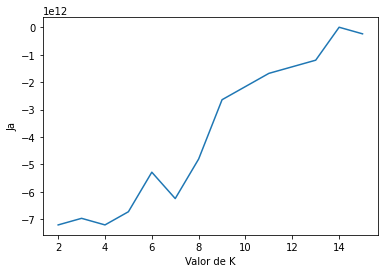

18.405741544837003


In [12]:
import matplotlib.pyplot
index = np.array(range(2,16))
matplotlib.pyplot.plot(index, Jvetor[2:])
matplotlib.pyplot.xlabel('Valor de K')
matplotlib.pyplot.ylabel('Ja')

matplotlib.pyplot.show()
print(max(Jvetor))

## Concluindo então que

In [16]:
###########OBTENDO O Ja de valor máximo correspondente ao melhor valor de K para nosso experimento#############
print("O melhor valor de é K=", Jvetor[2:].argmax(axis=0)+2)

O melhor valor de é K= 14
